## Происходит считывание данных с файла и их визуализация

In [1]:
# Рисовать графики сразу 
%matplotlib inline 

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# необходимые либы 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

# Для виджетов 
from IPython.display import display, clear_output
from ipywidgets import DatePicker, Checkbox, ToggleButton, HBox

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (24, 8)

### 1. Считываем данные генерации и потребления за год

In [2]:
# Объединяем колонки INTERVAL иM_DATE
def date_time_parser(d, t): 
    date = dt.datetime.strptime(d, '%d.%m.%Y %H:%M:%S')
    try: 
        hour = int(t)
    except ValueError:
        hour = 0
    finally:
        time = dt.time(hour)
    return dt.datetime.combine(date, time)
    
df = pd.read_csv('data/2014_2020.csv',
                 sep=';', parse_dates={'DATE_TIME':['M_DATE', "INTERVAL"]}, 
                 date_parser=date_time_parser)
# Удалим неопределенные? зоны 
df = df[df['POWER_SYS_ID'] != 0]
df

,DATE_TIME,PRICE_ZONE_ID,POWER_SYS_ID,E_USE_FACT,E_USE_PLAN,GEN_FACT,GEN_PLAN
121104,2014-01-01 00:00:00,1,530000,25090.0,24555,24279.0,25095
121105,2014-01-01 01:00:00,1,530000,24254.0,23759,24268.0,24902
121106,2014-01-01 02:00:00,1,530000,23341.0,23007,23703.0,23742
121107,2014-01-01 03:00:00,1,530000,22617.0,22379,22963.0,23628
121108,2014-01-01 04:00:00,1,530000,22167.0,22222,22894.0,23511
...,...,...,...,...,...,...,...
484411,2020-11-27 19:00:00,1,840000,12381.0,12408,13292.0,13338
484412,2020-11-27 20:00:00,1,840000,12202.0,12247,13467.0,12964
484413,2020-11-27 21:00:00,1,840000,11943.0,11934,12987.0,12788
484414,2020-11-27 22:00:00,1,840000,0.0,11564,0.0,12676


### 2. Фильтрация данных
#### 2.1 Дата

In [3]:
# Определяем от и до 
date_from = dt.datetime(2014, 1, 1, 0, 0)
date_to = dt.datetime(2020, 11, 27, 0, 0)

dpicker_from = DatePicker(
    description='От:',
    value = date_from
)
dpicker_to = DatePicker(
    description='До:',
    value=date_to
)

def time_2_datetime(t):
    return dt.datetime.combine(t, dt.datetime.min.time())

def on_from_button_clicked(b):
    global date_from
    date_from = time_2_datetime(b['new'])

def on_to_button_clicked(b):
    global date_to
    date_to = time_2_datetime(b['new'])

dpicker_from.observe(on_from_button_clicked, names='value')
dpicker_to.observe(on_to_button_clicked, names='value')

HBox([dpicker_from, dpicker_to])


#### 2.2 Ценовая зона

In [4]:
first_zone = True 
second_zone = True 

first_cb = Checkbox(
    description="1 ценовая зона",
    value=first_zone)

second_cb = Checkbox(
    description="2 ценовая зона",
    value=second_zone)

def on_first_clicked(cb):
    global first_zone
    first_zone = cb.new
    print("First zone ", first_zone)
    
def on_second_clicked(cb): 
    global second_zone
    second_zone = cb.new
    print("Second zone ", second_zone)
    
first_cb.observe(on_first_clicked, names='value')
second_cb.observe(on_second_clicked, names='value')

HBox([first_cb, second_cb])


#### 2.3 Объединенные энергосистемы

In [5]:
sys_list = df['POWER_SYS_ID'].unique()

# инициализируем выбранные 
sys_checked = dict((sys, False) for sys in sys_list)
sys_checked[530000] = True
# создаём кнопочки 
sys_cbs = [] 
for sys in sys_list: 
    def handler(local_sys): 
        def wrap(cb):
            global sys_checked
            sys_checked[local_sys] = cb.new 
            print(f"ОЭС {local_sys} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(sys),
        value = sys_checked[sys],
        )
    cb.observe(handler(sys), names='value')
    sys_cbs.append(cb)
    
HBox(sys_cbs)

#### 2.4 Выбираем графики 

In [6]:
# Список графиков 
graphs = ('E_USE_FACT','E_USE_PLAN', 'GEN_FACT', 'GEN_PLAN')
# инициализируем выбранные графики 
graph_checked = dict((gr, False) for gr in graphs)
graph_checked['E_USE_FACT'] = True
# создаём кнопочки 
graph_cbs = [] 
for graph in graphs: 
    def handler(local_graph): 
        def wrap(cb):
            global graph_checked
            graph_checked[local_graph] = cb.new 
            print(f"График {local_graph} {cb.new}")
        return wrap
    
    cb = Checkbox(
        description=str(graph),
        value = graph_checked[graph],
        )
    cb.observe(handler(graph), names='value')
    graph_cbs.append(cb)
    
HBox(graph_cbs)

### 3. Графики по заданному диапазону

ToggleButton(value=False, description='Show')

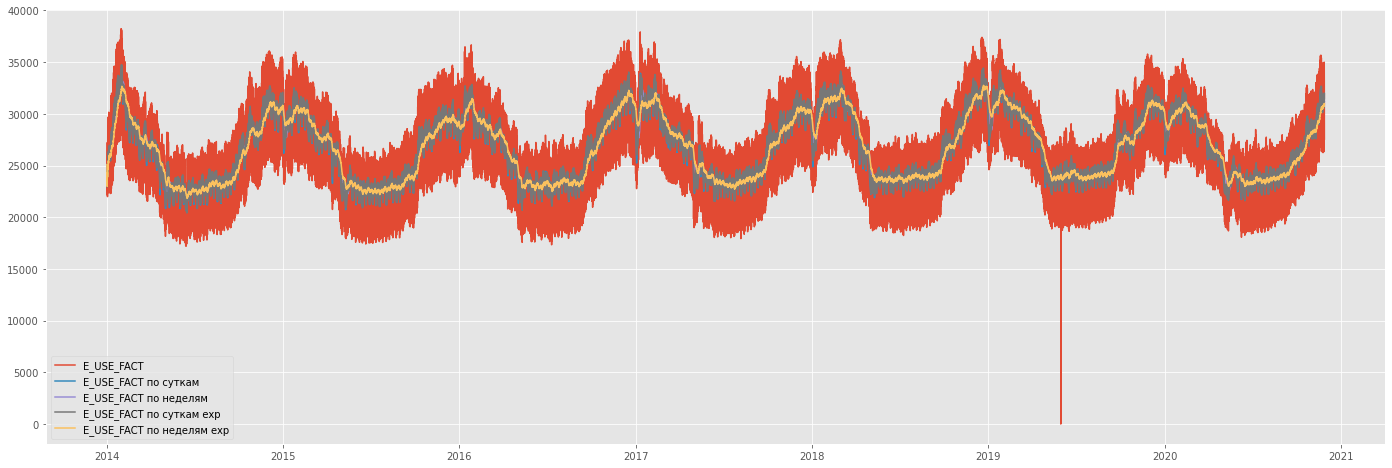

In [7]:
# фильтруем по датам 
def filter_by_date(data_frame): 
    global date_from, date_to
    return (date_from <= data_frame['DATE_TIME']) & (data_frame['DATE_TIME'] <= date_to)
    

# фильтруем по зонам 
def filter_by_zones(data_frame): 
    global first_zone, second_zone
    
    zone_filter = np.zeros(data_frame.shape[0], dtype=bool)
    for zone_checked, zone_value in [(first_zone, 1), (second_zone, 2)]:
        if zone_checked:
            zone_filter |= (data_frame['PRICE_ZONE_ID'] == zone_value)
    return zone_filter

# фильтруем по ОЭС
def filter_by_sys(data_frame):
    global sys_checked

    sys_filter = np.zeros(data_frame.shape[0], dtype=bool)
    for sys, checked in sys_checked.items():
        if checked: 
            sys_filter |= (data_frame["POWER_SYS_ID"] == sys)
    return sys_filter 


tb = ToggleButton(
    value=False,
    description='Show'
    )

def on_show(state):
    global df 
    global graphs, graph_checked
    
    # очищаем экран 
    clear_output(wait=True)
    display(tb)
    # фильтруем данные 
    filtered = df[filter_by_date(df) & filter_by_zones(df) & filter_by_sys(df)]
    
    # выводим на экран
    for sys_key in filtered['POWER_SYS_ID'].unique():
        sys_df = filtered[filtered['POWER_SYS_ID'] == sys_key]
        for power_key in graphs:
            if graph_checked[power_key]:
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key], label='{0}'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key].rolling(window=24).mean(), label='{0} по суткам'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key].rolling(window=24 * 7).mean(), label='{0} по неделям'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key].ewm(com=24).mean(), label='{0} по суткам exp'.format(power_key))
                plt.plot(sys_df['DATE_TIME'], sys_df[power_key].ewm(com=24 * 7).mean(), label='{0} по неделям exp'.format(power_key))
    plt.legend()
tb.observe(on_show, names='value')
on_show({})



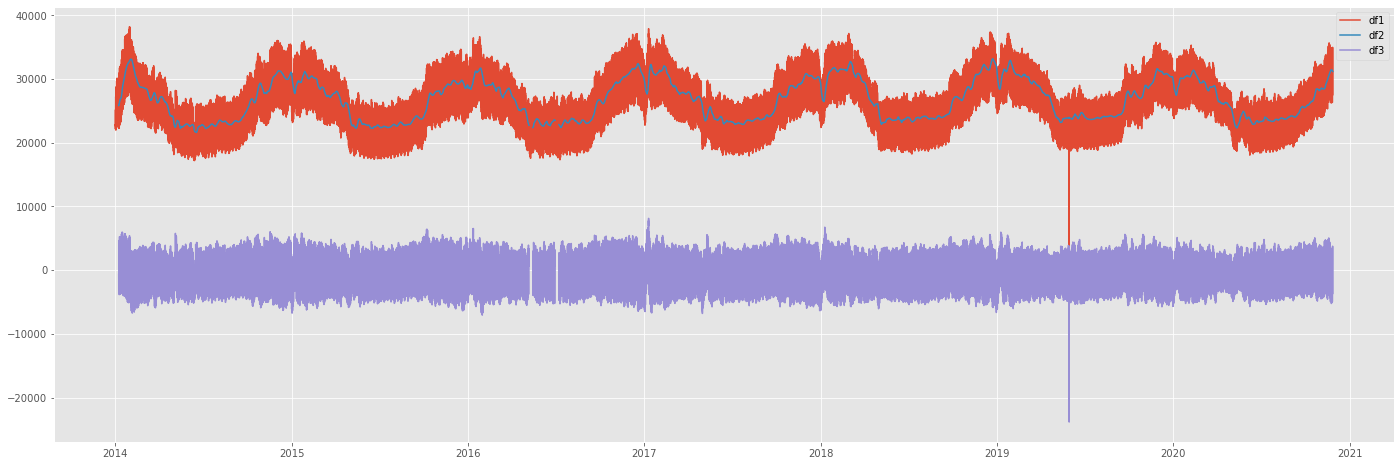

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

filtered = df[filter_by_date(df) & filter_by_zones(df) & filter_by_sys(df)]
# Исходные данные
df1 = filtered[['DATE_TIME', 'E_USE_FACT']]
# Тренд
df2 = df1.copy()
df2['E_USE_FACT'] = df1['E_USE_FACT'].rolling(window=24 * 7).mean()
# Данные без тренда
df3 = df1.copy()
df3['E_USE_FACT'] = df1['E_USE_FACT'] - df2['E_USE_FACT']

plt.plot(df1['DATE_TIME'], df1['E_USE_FACT'], label='df1')
plt.plot(df2['DATE_TIME'], df2['E_USE_FACT'], label='df2')
plt.plot(df3['DATE_TIME'], df3['E_USE_FACT'], label='df3')
plt.legend()

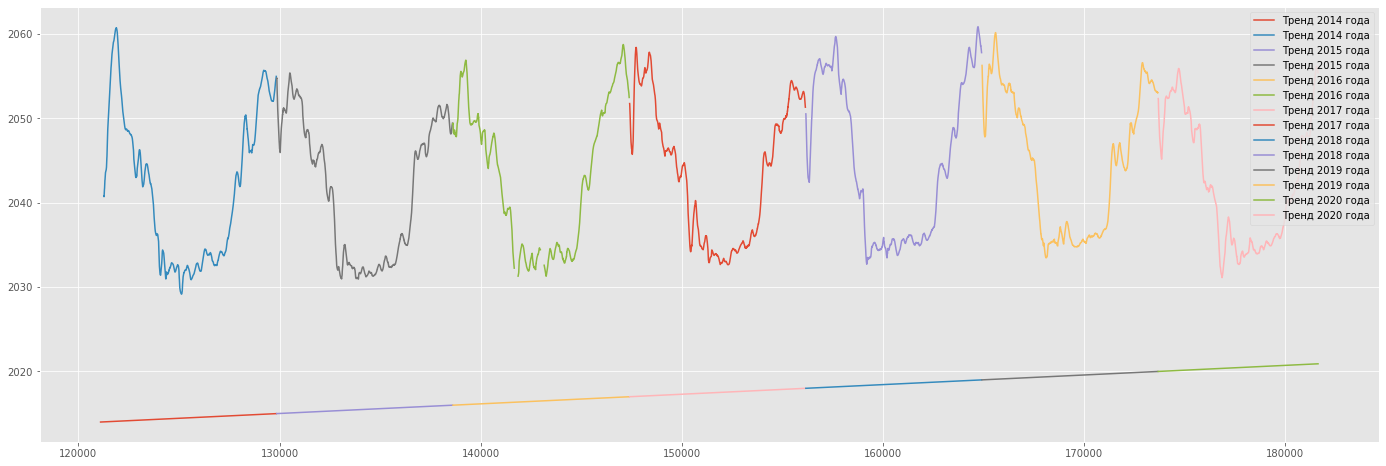

In [12]:
# Функция выделения кусков по годам
def filter_by_year(data_frame, year):
    start = dt.datetime(year, 1, 1, 0, 0)
    finish = dt.datetime(year, 12, 31, 0, 0)
    return (start <= data_frame['DATE_TIME']) & (data_frame['DATE_TIME'] <= finish)

for year in range(2014, 2021):
    df_year = df2[filter_by_year(df2, year)]
    plt.plot(np.linspace(), df_year['E_USE_FACT'], label='Тренд {0} года'.format(year))
plt.legend()

In [21]:
df_year

,DATE_TIME,E_USE_FACT
173688,2020-01-01 00:00:00,30079.375000
173689,2020-01-01 01:00:00,30076.880952
173690,2020-01-01 02:00:00,30073.833333
173691,2020-01-01 03:00:00,30067.732143
173692,2020-01-01 04:00:00,30057.976190
...,...,...
181628,2020-11-26 20:00:00,31214.827381
181629,2020-11-26 21:00:00,31212.178571
181630,2020-11-26 22:00:00,31210.708333
181631,2020-11-26 23:00:00,31207.392857
